# Image Captioning with Attention

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image

import itertools

tf.random.set_seed(1)


In [ ]:
tf.data.Dataset.from_tensor_slices(((img_mini, img_mini_inception), label_array)).batch(32)

for (batch, ((raw_img, img_tensor), target)) in

.from_tensor_slices((raw_img, inception_img, label))

Loading the Data. The data consist of pictures and labels of linear functions

In [2]:
import cv2
import os

def load_images_from_folder(folder, n_imgs=-1):
    images = []
    image_nums = []
    for filename in os.listdir(folder)[:n_imgs]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_nums.append(filename.strip('.png'))
    return images, image_nums

folder="../../linear_fcns/images"

In [48]:
images, fnames = load_images_from_folder(folder)

In [49]:
labels = pd.read_csv('../../linear_fcns/data.csv')

In [50]:
labels['img_number'] = labels['filename'].apply(lambda x: x.split('/')[-1].strip('.png'))

In [51]:
labels.head()

,latex,filename,img_number
0,0a+1=2,linear_fcns/images/0.png,0
1,0b+1=2,linear_fcns/images/1.png,1
2,0c+1=2,linear_fcns/images/2.png,2
3,0d+1=2,linear_fcns/images/3.png,3
4,0e+1=2,linear_fcns/images/4.png,4


In [52]:
label_array = labels[labels['img_number'].isin(fnames)]['latex'].values

In [53]:
label_array

array(['0a+1=2', '0b+1=2', '0c+1=2', ..., '9x+8=7', '9y+8=7', '9z+8=7'],
      dtype=object)

For the labels we need to add start and end tokens so the model can recognize what to write.

In [54]:
label_array = [f'\t{la}\n' for la in label_array]

Let's reshape the images so we can plot them.

In [55]:
images_for_split = images
images = np.array(images)
images = 255 - images
# images = tf.image.rgb_to_grayscale(images)
images = np.array(images)
images.shape

(18719, 72, 360, 3)

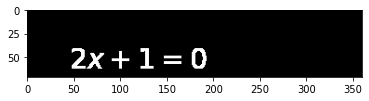

In [56]:
plt.imshow(images[0].squeeze())

Now we can process them and prepare them for inceptionv3 which is transfer learning

In [59]:
img_mini = tf.image.resize_with_pad(images, 299, 299)

In [97]:
num_imgs = img_mini.shape[0]
train_idx = np.random.choice(range(num_imgs), 100)

img_train = img_mini[train_idx]
img_name = cap_vector[train_idx]

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 2830, 14929, 12465, 16402,  8104, 14038, 17766,  1829, 13174,
       11251, 15471, 12009,  5071,  2603,  4425,  9768,  1943,  8632,
        6188,  4398, 18261,  5349, 13987, 15928,   738, 14697, 12020,
       16314,  8958,  3925,  8128, 14882,  9598,  5867, 10563, 16881,
        3357, 10353, 16217,   243, 13274, 18014,  9235,  6715,  2259,
        9660, 14345, 13089,  3700, 10766,  4100,  1819, 12008, 13602,
       17525, 13471, 11309,  7368,  1931,  9365,  9112, 10777,  6283,
        8225, 17708,  7262,  1913,  6871,  9255,  5837,  6854, 13213,
       10469, 15012, 11112, 14286, 15582, 15905, 14262,   402,  8609,
       12332,  1941,  7581,  9770, 14977,  3392,  9025, 10606,  4890,
        5827,  3996,  1317,  8973, 18561, 11405, 14945, 15557, 13221,
        1335])

In [12]:
img_mini = tf.keras.applications.inception_v3.preprocess_input(img_mini)

In [13]:
test_img = images[2222]

Now we can load the features of the inceptionv3 model as seen below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


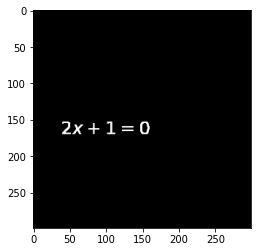

In [14]:
plt.imshow(tf.squeeze(img_mini[0]))

In [15]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [84]:

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices((img_mini, label_array)).batch(300)
c = 1

for img, label in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    p = f'Batch Features/batch_features{c}'
    c = c+1 
     #path_of_feature = p.numpy().decode("utf-8")
    np.save(p, batch_features)

In [16]:
img_load = np.load('Batch Features/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'Batch Features/batch_features{i}.npy')
    img_load = np.concatenate((img_load, img_add))

In [17]:
img_load.shape

(18000, 64, 2048)

### Tokenizing the labels

Now we can pad the labels to make sure they are all the same length.

In [18]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
# Choose the top 5000 words from the vocabulary
top_k = 45
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=' ',
                                                  char_level=True)
tokenizer.fit_on_texts(label_array)
train_seqs = tokenizer.texts_to_sequences(label_array)

# Padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(label_array)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [20]:
tokenizer.get_config()

{'num_words': 45,
 'filters': ' ',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': '<unk>',
 'document_count': 18719,
 'word_counts': '{"\\t": 18719, "0": 5615, "a": 720, "+": 18719, "1": 5616, "=": 18719, "2": 5616, "\\n": 18719, "b": 720, "c": 719, "d": 720, "e": 720, "f": 720, "g": 720, "h": 720, "i": 720, "j": 720, "k": 720, "l": 720, "m": 720, "n": 720, "o": 720, "p": 720, "q": 720, "r": 720, "s": 720, "t": 720, "u": 720, "v": 720, "w": 720, "x": 720, "y": 720, "z": 720, "3": 5616, "4": 5615, "5": 5616, "6": 5616, "7": 5616, "8": 5616, "9": 5615}',
 'word_docs': '{"a": 720, "0": 5615, "\\t": 18719, "+": 18719, "1": 5616, "2": 5616, "=": 18719, "\\n": 18719, "b": 720, "c": 719, "d": 720, "e": 720, "f": 720, "g": 720, "h": 720, "i": 720, "j": 720, "k": 720, "l": 720, "m": 720, "n": 720, "o": 720, "p": 720, "q": 720, "r": 720, "s": 720, "t": 720, "u": 720, "v": 720, "w": 720, "x": 720, "y": 720, "z": 720, "3": 5616, "4": 5615, "5": 5616, "6": 5616, "7": 5616, "8": 5

In [21]:
max_length

8

In [22]:
print(f'{label_array[0]} -> {train_seqs[0]}')

	0a+1=2
 -> [2, 13, 16, 3, 6, 4, 7, 5]


In [23]:
import json

char_to_int_map = tokenizer.get_config()['word_index']
char_to_int_map = json.loads(char_to_int_map)
[char_to_int_map[c] for c in label_array[0]]

[2, 13, 16, 3, 6, 4, 7, 5]

### Train Test Split

This kind of makes a train test split but I don't think it is exactly what we want.

For the model

In [41]:
num_imgs = img_mini.shape[0]
train_idx = np.random.choice(range(num_imgs), 100)

img_train = img_mini[train_idx,:,:,:]
img_name = cap_vector[train_idx,:]

In [47]:
type(img_mini)

tensorflow.python.framework.ops.EagerTensor

In [45]:
img_train = img_mini[train_idx,:,:,:]
img_name = cap_vector[train_idx,:]

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([10733, 17229, 17769, 15330,  9628,   116, 12195, 13510,  7803,
        7463,  6609, 10402, 18154, 12270,  2702, 18442, 10090, 11288,
       17982,  6372,  8607, 13762,  2050,  7421,  5708,  8967, 14456,
       12386,  2206,     6,  1015,  4956,  4909,  9578,  5294,  5393,
        9942,   343, 16572,  8109, 14911, 14181, 11308,  5144, 10642,
       12590, 11417, 10147,   257,  3935, 15834, 12918, 17428,  5455,
       17209, 11202, 10853,  6114,  6980,  7066,  1923,  7762,  2255,
       18052,  8845, 13898, 17124,  1079,  5529,  2453, 14905,  2964,
           7, 13142, 12875,  5117,   591, 12551,  6196,  3656,  9389,
       13106, 11474, 13351,  3059, 10301, 11557, 14992, 11116,  6416,
       10465, 11945, 12984, 10701, 17347,   713, 11715, 16749, 18156,
       11070])

In [94]:
img_train.shape

TensorShape([18719, 299, 299, 3])

In [26]:
# Feel free to change these parameters according to your system's configuration
embedding_dim = 45
units = 32
vocab_size = top_k + 1
num_steps = len(img_train) // 1
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model

Below we are defining the attention, the encoder and the decoder. The encoder is just a fully connected layer from the features already extracted.

In [27]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [28]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        #print(f'This is x: {x}')
        x = tf.nn.relu(x)
        #print(f'This is x: {x}')
        return x

In [29]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        #print('decoder attention complete')

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #print('decoder embedding complete')
        #print(f'x.shape = {x.shape}')
        #print(f'context_vector.shape = {context_vector.shape}')

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        #print('decoder embedding + context vector complete')

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        #print('decoder gru complete')

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        #print('decoder fc1 complete')

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        #print('decoder reshape complete')

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        #print('decoder fc2 complete')

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [32]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [33]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
      start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
      # restoring the latest checkpoint in checkpoint_path
      ckpt.restore(ckpt_manager.latest_checkpoint)

In [34]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [35]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

          # initializing the hidden state for each batch
          # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    #print(f'hidden complete: {hidden}')

    # Create a vector of all \t indices to indicate the start of prediction
    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)
    #print(f'dec_input complete: {dec_input}')

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        #print('encoder complete')
        #print(f'features.shape = {features.shape}')

        # iterate through timesteps to predict the i'th character
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            #print('decoder complete')

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [36]:
new = cap_vector[:18000]

In [37]:
image_dataset_encoded = tf.data.Dataset.from_tensor_slices((img_load, new)).batch(300)

In [39]:
import time
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(image_dataset_encoded):
      #print(img_tensor.shape)
      #print(target.shape)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save() 
    print(num_steps)
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 3 Batch 0 Loss 1.3649
Epoch 3 Batch 1 Loss 1.3335
Epoch 3 Batch 2 Loss 1.3472
Epoch 3 Batch 3 Loss 1.3141
Epoch 3 Batch 4 Loss 1.3103
Epoch 3 Batch 5 Loss 1.3047
Epoch 3 Batch 6 Loss 1.3213
Epoch 3 Batch 7 Loss 1.3506
Epoch 3 Batch 8 Loss 1.3521
Epoch 3 Batch 9 Loss 1.3346
Epoch 3 Batch 10 Loss 1.3331
Epoch 3 Batch 11 Loss 1.3171
Epoch 3 Batch 12 Loss 1.2990
Epoch 3 Batch 13 Loss 1.3079
Epoch 3 Batch 14 Loss 1.3417
Epoch 3 Batch 15 Loss 1.3186
Epoch 3 Batch 16 Loss 1.3215
Epoch 3 Batch 17 Loss 1.3172
Epoch 3 Batch 18 Loss 1.2926
Epoch 3 Batch 19 Loss 1.3055
Epoch 3 Batch 20 Loss 1.3132
Epoch 3 Batch 21 Loss 1.3527
Epoch 3 Batch 22 Loss 1.3410
Epoch 3 Batch 23 Loss 1.3430
Epoch 3 Batch 24 Loss 1.3209
Epoch 3 Batch 25 Loss 1.2959
Epoch 3 Batch 26 Loss 1.2854
Epoch 3 Batch 27 Loss 1.3053
Epoch 3 Batch 28 Loss 1.3306
Epoch 3 Batch 29 Loss 1.3302
Epoch 3 Batch 30 Loss 1.3141
Epoch 3 Batch 31 Loss 1.3204
Epoch 3 Batch 32 Loss 1.3033
Epoch 3 Batch 33 Loss 1.2998
Epoch 3 Batch 34 Loss 1.

Epoch 7 Batch 34 Loss 1.2893
Epoch 7 Batch 35 Loss 1.3238
Epoch 7 Batch 36 Loss 1.3128
Epoch 7 Batch 37 Loss 1.3026
Epoch 7 Batch 38 Loss 1.2972
Epoch 7 Batch 39 Loss 1.2752
Epoch 7 Batch 40 Loss 1.2782
Epoch 7 Batch 41 Loss 1.2890
Epoch 7 Batch 42 Loss 1.3205
Epoch 7 Batch 43 Loss 1.3010
Epoch 7 Batch 44 Loss 1.3033
Epoch 7 Batch 45 Loss 1.2886
Epoch 7 Batch 46 Loss 1.2705
Epoch 7 Batch 47 Loss 1.2682
Epoch 7 Batch 48 Loss 1.2927
Epoch 7 Batch 49 Loss 1.3015
Epoch 7 Batch 50 Loss 1.3118
Epoch 7 Batch 51 Loss 1.2960
Epoch 7 Batch 52 Loss 1.2954
Epoch 7 Batch 53 Loss 1.2641
Epoch 7 Batch 54 Loss 1.2726
Epoch 7 Batch 55 Loss 1.2836
Epoch 7 Batch 56 Loss 1.3369
Epoch 7 Batch 57 Loss 1.3426
Epoch 7 Batch 58 Loss 1.3274
Epoch 7 Batch 59 Loss 1.3234
18719
Epoch 7 Loss 0.004148
Time taken for 1 epoch 37.506791830062866 sec

Epoch 8 Batch 0 Loss 1.3154
Epoch 8 Batch 1 Loss 1.2939
Epoch 8 Batch 2 Loss 1.2971
Epoch 8 Batch 3 Loss 1.2751
Epoch 8 Batch 4 Loss 1.2692
Epoch 8 Batch 5 Loss 1.2710
Epo

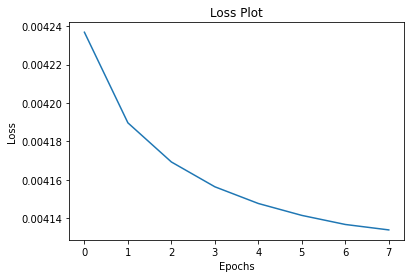

In [40]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluate

In [91]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    #print(temp_input)
    img_tensor_val = image_features_extract_model(temp_input)
    #print(img_tensor_val)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    #print(img_tensor_val)
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['\t']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.random.categorical(predictions, 1)[0][0]
        predicted_id = int(predicted_id)
        result.append(tokenizer.index_word[predicted_id])
        #print(tokenizer.index_word[predicted_id])
        ind = np.argpartition(predictions, -4)[0][-4:]
        print(f'These are the top choices {"".join(tokenizer.index_word[c] for c in ind)}')
        print(f'This are the probabilities {predictions.numpy()[0,ind]}')

        if tokenizer.index_word[predicted_id] == '\n':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [92]:
test_img1 = img_mini[201]
test_img2 = img_mini[4001]
test_img3 = img_mini[6001]
test_img4 = img_mini[11201]
test_img5 = img_mini[3601]
label_array5 = label_array[0]
test_img6 = img_mini[10011]
label_array6 = label_array[10011]
test_img7 = img_mini[16000]
label_array7 = label_array[16000]

In [93]:
def plot_attention(image, result, attention_plot):
    
    #-1 goes to zero
    temp_image = np.array(image)

    fig = plt.figure(figsize=(10, 10))
    #print(result)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show();

Run attention_plot to see what it looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


These are the top choices 2
7+
This are the probabilities [2.682321  3.7328415 3.3995636 4.446071 ]
These are the top choices 2
7+
This are the probabilities [2.6999753 3.7498517 3.4296846 4.5382566]
These are the top choices +27

This are the probabilities [2.6078465 2.7104177 3.0411694 4.88854  ]
These are the top choices 2
7+
This are the probabilities [2.7027125 3.7911294 3.4198916 4.462781 ]
These are the top choices +27

This are the probabilities [2.6074605 2.7116115 3.041341  4.894889 ]
Prediction Caption: + 9 + 9 

	2x+1=3



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: num must be 1 <= num <= 4, not 5

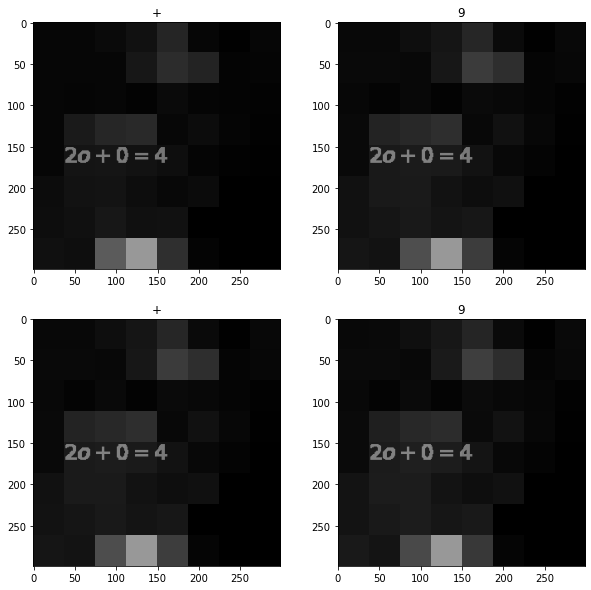

In [96]:
result, attention_plot = evaluate(test_img2)
print ('Prediction Caption:', ' '.join(result))
print(label_array[4001])
plot_attention(test_img2, result, attention_plot)
# opening the image
plt.imshow(test_img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction Caption: 5 n + 5 = 0 



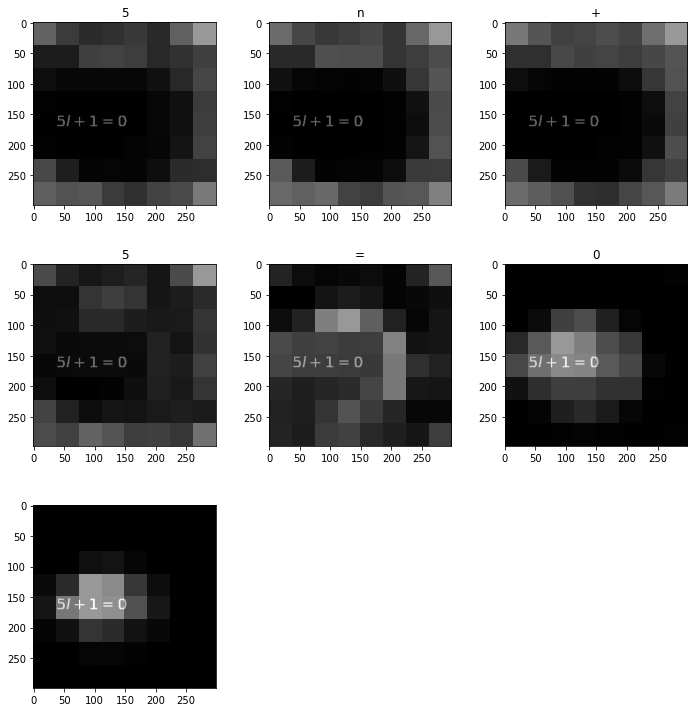

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


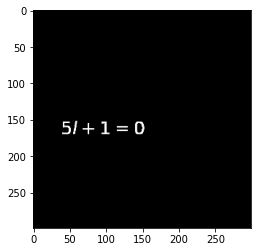

In [151]:
result, attention_plot = evaluate(test_img3)
print ('Prediction Caption:', ' '.join(result))
plot_attention(test_img3, result, attention_plot)
# opening the image
plt.imshow(test_img3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction Caption: 8 m + 2 = 8 



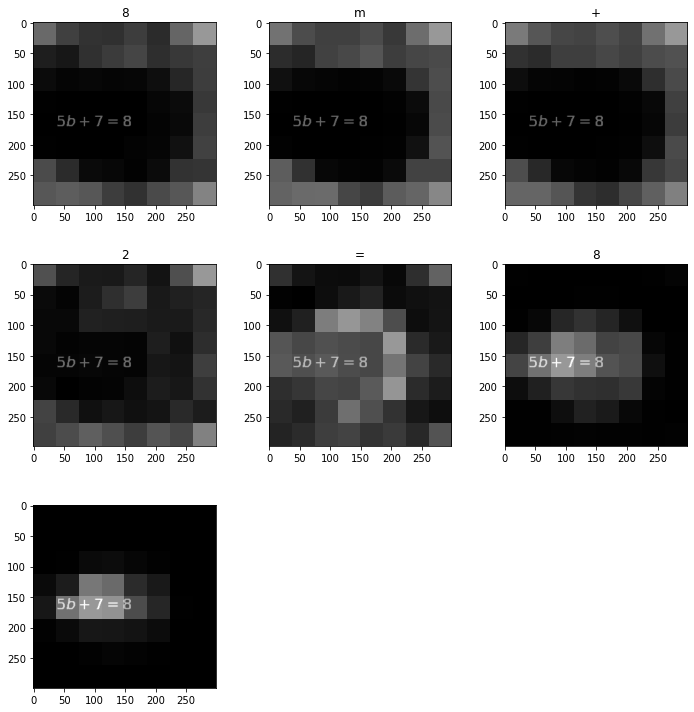

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


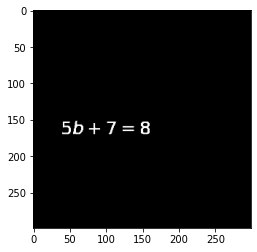

In [156]:
result, attention_plot = evaluate(test_img4)
print ('Prediction Caption:', ' '.join(result))
plot_attention(test_img4, result, attention_plot)
# opening the image
plt.imshow(test_img4)